In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

root_dir = "../"
sys.path.append(root_dir)
from configs import get_config
from classifiers import get_classifier
from datasets import get_dataset
from notebooks.utils import viz_explanation

config_name = "cub"
topic_config_dict = {
    "data.explanation_length": 12,
    "listener.type": "topic",
    "listener.gamma": 0.4,
    # "listener.prior": 6 * [1 / 6],
    "listener.prior": [0.0, 0.0, 1 / 3, 1 / 3, 1 / 3, 0.0],
    "listener.temperature_scale": [1.0, 2.0, 4.0, 8.0],
    "speaker.alpha": [0.0, 0.2],
}
topic_config = get_config(config_name, config_dict=topic_config_dict)
prior = np.array(topic_config.listener.prior)

claim_config_dict = topic_config_dict.copy()
claim_config_dict["listener.type"] = "claim"
claim_config = get_config(config_name, config_dict=claim_config_dict)

lit_topic_configs, prag_topic_configs = topic_config.sweep(["speaker.alpha"])

lit_topic_results = [
    c.get_results() for c in lit_topic_configs.sweep(["listener.temperature_scale"])
]
prag_topic_results = [
    c.get_results() for c in prag_topic_configs.sweep(["listener.temperature_scale"])
]

lit_claim_config, prag_claim_config = claim_config.sweep(["speaker.alpha"])
lit_claim_results = lit_claim_config.get_results()
prag_claim_results = prag_claim_config.get_results()

classifier = get_classifier(topic_config, device="cpu")
dataset = get_dataset(
    topic_config, train=False, transform=classifier.preprocess, return_attribute=True
)
classes = dataset.classes

attribute_dir = os.path.join(root_dir, "data", "CUB", "attributes")
with open(os.path.join(attribute_dir, "topics.txt"), "r") as f:
    lines = f.readlines()
    lines = [l.strip() for l in lines]
    topics = [l.split()[1].replace("_", " ") for l in lines]

sns.set_theme()
sns.set_context("paper")

/cis/home/zwang/Projects/pragmatixs/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cis/home/zwang/Projects/pragmatixs/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


768 1024


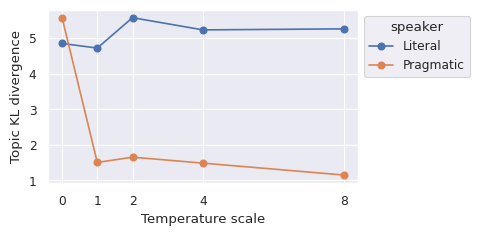

In [2]:
figure_dir = os.path.join(
    root_dir, "figures", topic_config.data.dataset.lower(), "topic_kl"
)
os.makedirs(figure_dir, exist_ok=True)


def topic_kl(results):
    explanation_topics = np.array(results["explanation_topics"].values.tolist())

    return np.sum(
        explanation_topics * np.log((explanation_topics + 1e-08) / (prior + 1e-08)),
        axis=-1,
    )


lit_topic_kl = [topic_kl(r) for r in lit_topic_results]
prag_topic_kl = [topic_kl(r) for r in prag_topic_results]

lit_claim_kl = topic_kl(lit_claim_results)
prag_claim_kl = topic_kl(prag_claim_results)

mu_lit_topic_kl = np.mean(lit_topic_kl, axis=-1).tolist()
mu_prag_topic_kl = np.mean(prag_topic_kl, axis=-1).tolist()

mu_lit_claim_kl = np.mean(lit_claim_kl)
mu_prag_claim_kl = np.mean(prag_claim_kl)

_, ax = plt.subplots(figsize=(16 / 4, 9 / 4))
ax.plot(
    [0] + lit_topic_configs.listener.temperature_scale,
    [mu_lit_claim_kl] + mu_lit_topic_kl,
    label="Literal",
    marker="o",
)
ax.plot(
    [0] + prag_topic_configs.listener.temperature_scale,
    [mu_prag_claim_kl] + mu_prag_topic_kl,
    label="Pragmatic",
    marker="o",
)
ax.set_xlabel("Temperature scale")
ax.set_ylabel("Topic KL divergence")
ax.set_xticks([0] + lit_topic_configs.listener.temperature_scale)
ax.legend(title="speaker", loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig(
    os.path.join(
        figure_dir,
        f"temperature_{','.join(map(lambda x: f'{x:.2f}', prag_topic_configs.listener.prior))}.pdf",
    ),
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(
        figure_dir,
        f"temperature_{','.join(map(lambda x: f'{x:.2f}', prag_topic_configs.listener.prior))}.png",
    ),
    bbox_inches="tight",
)
plt.show()

In [3]:
best_temperature_idx = np.argmin(mu_prag_topic_kl)
best_temperature = prag_topic_configs.listener.temperature_scale[best_temperature_idx]
print(best_temperature_idx, best_temperature)

_lit_topic_results = lit_topic_results[best_temperature_idx]
_prag_topic_results = prag_topic_results[best_temperature_idx]
for r in [
    _lit_topic_results,
    _prag_topic_results,
    lit_claim_results,
    prag_claim_results,
]:
    r["listener_prediction"] = r["action"].apply(lambda x: np.argmax(x))
    r["correct"] = r["prediction"] == r["listener_prediction"]
    print(f"{r['correct'].mean():.2%}")

mask = (_prag_topic_results["correct"] & prag_claim_results["correct"]).values

_prag_topic_kl = prag_topic_kl[best_temperature_idx]
kl_diff = prag_claim_kl - _prag_topic_kl
sorted_idx = np.argsort(kl_diff)[::-1]
sorted_mask = mask[sorted_idx]
sorted_idx = sorted_idx[sorted_mask]

3 8.0
21.93%
54.24%
21.80%
56.45%


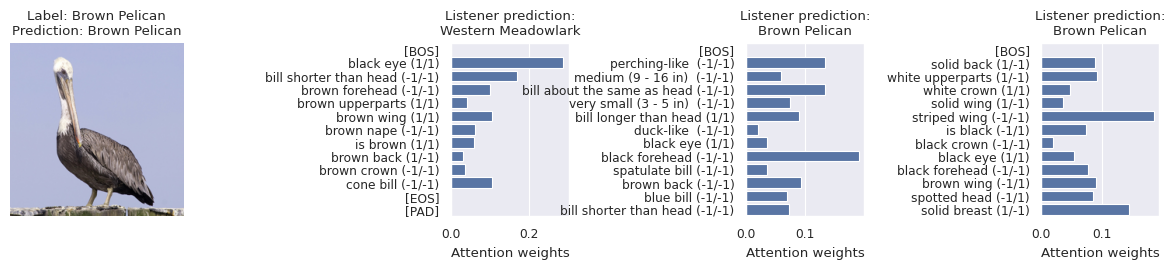

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


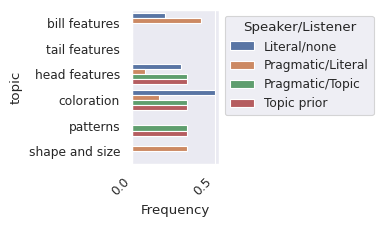

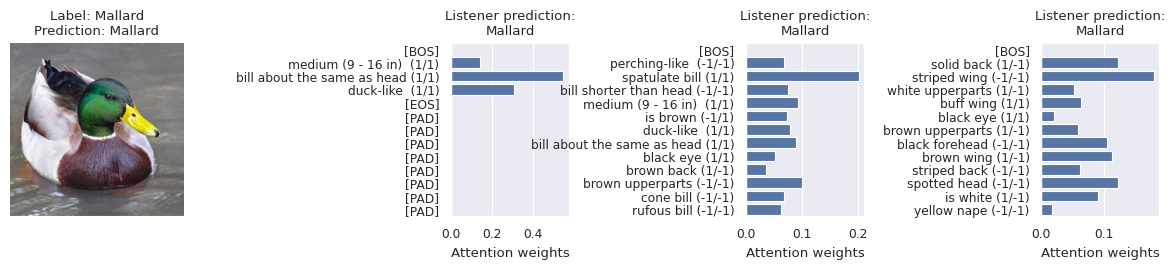

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


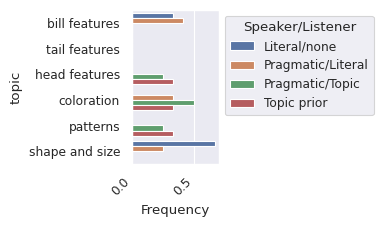

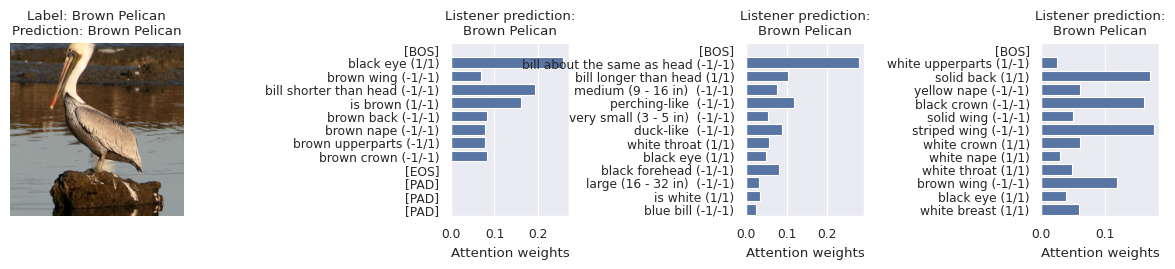

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


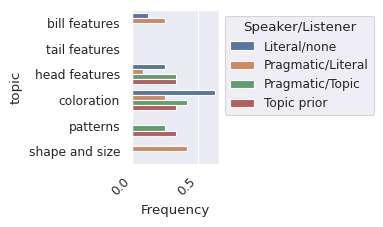

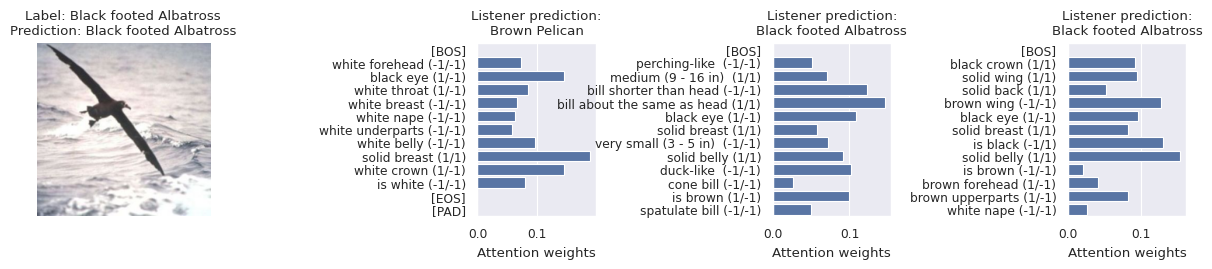

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


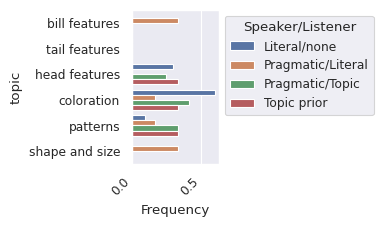

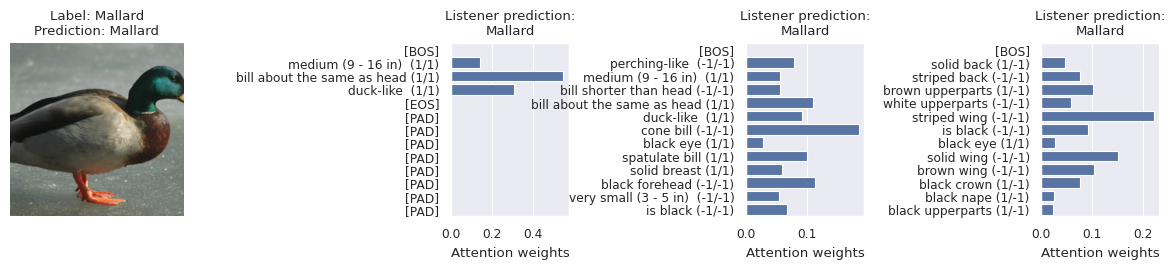

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


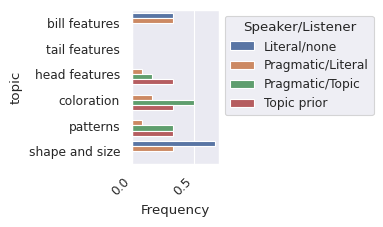

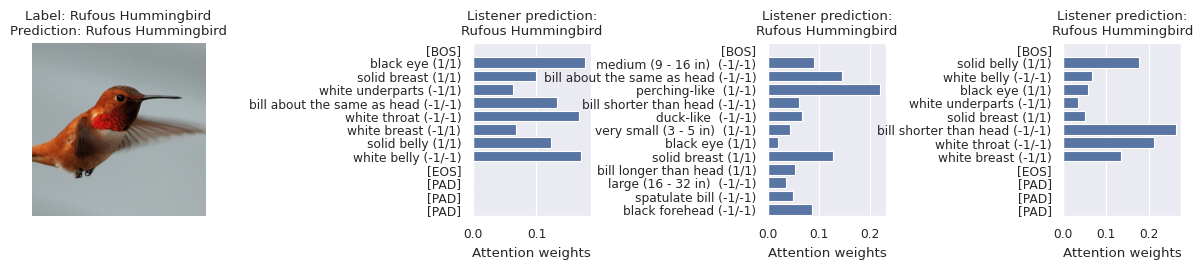

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


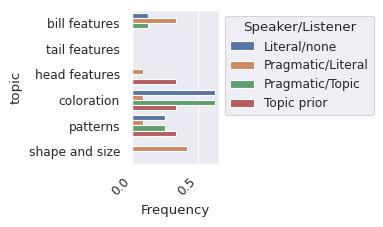

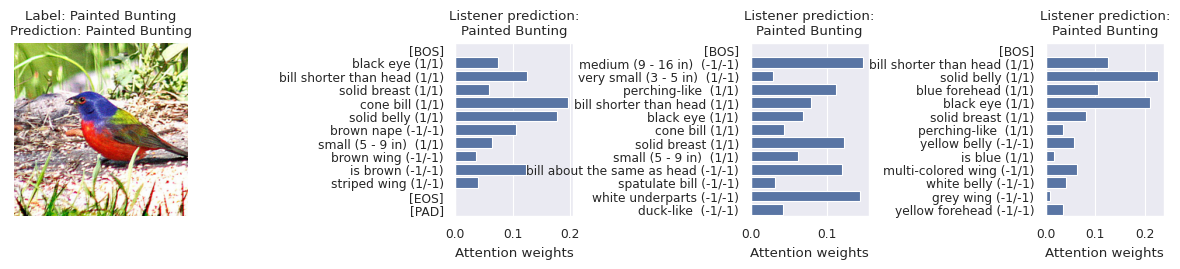

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


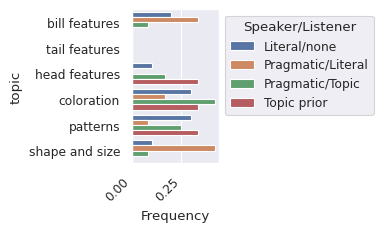

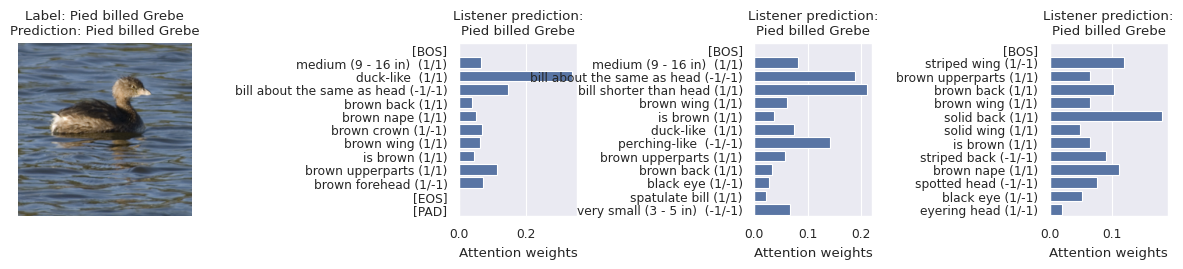

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


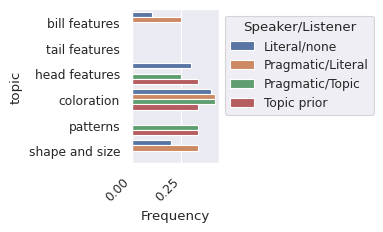

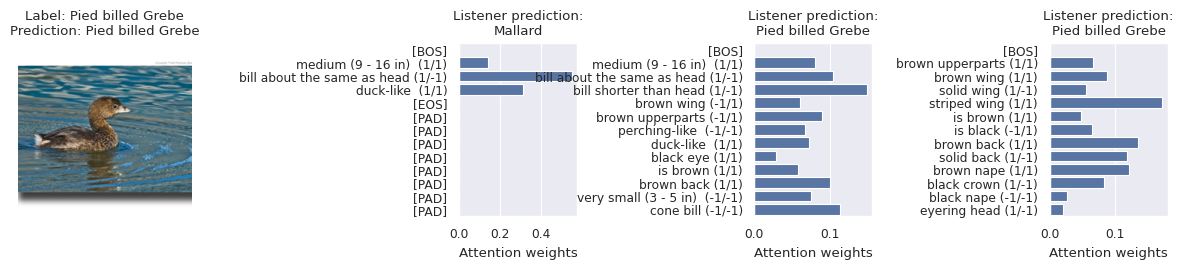

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


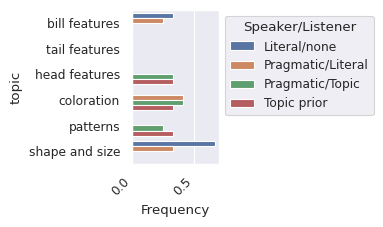

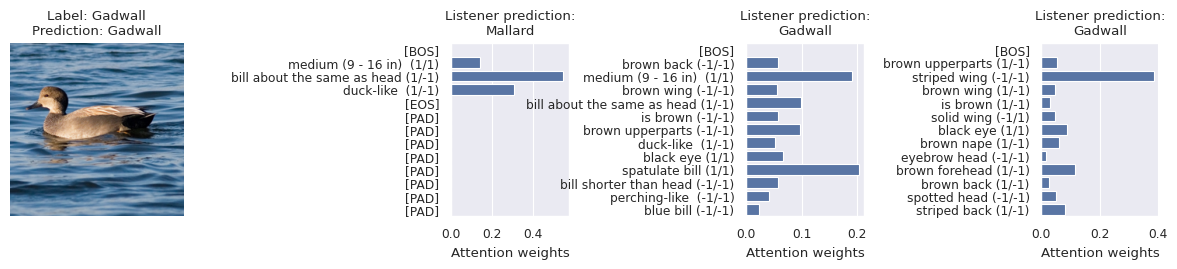

/tmp/ipykernel_14225/701531013.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


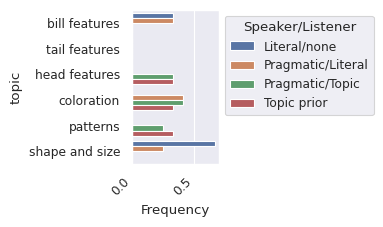

In [4]:
figure_dir = os.path.join(
    root_dir,
    "figures",
    prag_topic_configs.sweep(["listener.temperature_scale"])[
        best_temperature_idx
    ].run_name(),
)
os.makedirs(figure_dir, exist_ok=True)

m = 10
for _idx in sorted_idx[:m]:
    image, label, image_attribute = dataset[_idx]

    idx_lit_claim_results = lit_claim_results.iloc[_idx]
    idx_prag_claim_results = prag_claim_results.iloc[_idx]
    idx_prag_topic_results = _prag_topic_results.iloc[_idx]
    assert idx_prag_claim_results["prediction"] == idx_prag_topic_results["prediction"]
    cls_prediction = idx_prag_claim_results["prediction"]

    image = (image * 1 / 2) + 1 / 2

    _, axes = plt.subplots(
        1,
        4,
        figsize=(16, 9 / 4),
        gridspec_kw={"width_ratios": [3, 1, 1, 1], "wspace": 1.0},
    )
    ax = axes[0]
    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Label: {classes[label]}\nPrediction: {classes[cls_prediction]}")

    ax = axes[1]
    viz_explanation(dataset, lit_claim_results, _idx, ax)

    ax = axes[2]
    viz_explanation(dataset, prag_claim_results, _idx, ax)

    ax = axes[3]
    viz_explanation(dataset, _prag_topic_results, _idx, ax)
    plt.savefig(
        os.path.join(figure_dir, f"{_idx}_explanations.pdf"), bbox_inches="tight"
    )
    plt.savefig(
        os.path.join(figure_dir, f"{_idx}_explanations.png"), bbox_inches="tight"
    )
    plt.show()

    topic_data = {"topic": [], "probability": [], "speaker": []}
    for speaker, speaker_results in [
        ("Literal/none", idx_lit_claim_results),
        ("Pragmatic/Literal", idx_prag_claim_results),
        ("Pragmatic/Topic", idx_prag_topic_results),
    ]:
        explanation_topics = speaker_results["explanation_topics"]
        for i, topic in enumerate(topics):
            topic_data["topic"].append(topic)
            topic_data["probability"].append(explanation_topics[i])
            topic_data["speaker"].append(speaker)
    for i, topic in enumerate(topics):
        topic_data["topic"].append(topic)
        topic_data["probability"].append(prior[i])
        topic_data["speaker"].append("Topic prior")

    _, ax = plt.subplots(figsize=(9 / 8, 16 / 8))
    topic_df = pd.DataFrame(topic_data)
    sns.barplot(data=topic_data, y="topic", x="probability", hue="speaker", ax=ax)
    ax.set_xlabel("Frequency")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend(title="Speaker/Listener", loc="upper left", bbox_to_anchor=(1, 1))
    plt.savefig(os.path.join(figure_dir, f"{_idx}_topics.pdf"), bbox_inches="tight")
    plt.savefig(os.path.join(figure_dir, f"{_idx}_topics.png"), bbox_inches="tight")
    plt.show()